## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

In [1]:
 import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

! pip install --upgrade seaborn


# Load Metadata
metadata_filename = '/data/crisdb/metadata.csv'
metadata = pd.read_csv(metadata_filename)

# Print column names to debug
print("Column names in metadata file:", metadata.columns)


Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)
Column names in metadata file: Index(['subject', 'age', 'sex'], dtype='object')


In [2]:

# Create metadata dictionary with the correct column names
metadata_dict = metadata.set_index('subject').to_dict(orient='index')

# Load the dataset
hr_filenames = glob.glob('/data/crisdb/*.npz')

def AgeAndRHR(metadata_dict, filename):
    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)
    
    # Find the subject ID from the filename.
    subject_id = os.path.basename(filename).replace('.npz', '')
    
    # Find the age group for this subject in metadata.
    age_group = metadata_dict[subject_id]['age']
    
    # Find the sex for this subject in metadata.
    sex = metadata_dict[subject_id]['sex']
    
    return age_group, sex, rhr

# Create a DataFrame with the computed values
df = pd.DataFrame(data=[AgeAndRHR(metadata_dict, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])



In [10]:
# Compute the mean, standard deviation, and count
summary_df = df.groupby(['age_group', 'sex']).apply(
    lambda x: pd.Series({
        'mean_rhr': x['rhr'].mean(),
        'std_rhr': x['rhr'].std(),
        'count': x['rhr'].count()
    })
).reset_index()

# Calculate the 95% confidence interval
summary_df['ci'] = 1.96 * (summary_df['std_rhr'] / np.sqrt(summary_df['count']))

print(summary_df)


   age_group     sex   mean_rhr    std_rhr  count         ci
0      35-39  Female  64.936157  10.743882    4.0  10.529004
1      35-39    Male  65.092105  11.897925   24.0   4.760162
2      40-44  Female  72.880497  13.096411    8.0   9.075350
3      40-44    Male  63.046920  12.343532   54.0   3.292294
4      45-49  Female  71.109613  19.509168   15.0   9.873001
5      45-49    Male  65.359438  14.383833  109.0   2.700334
6      50-54  Female  70.464430  14.508093   18.0   6.702397
7      50-54    Male  64.594842  14.592072  146.0   2.366991
8      55-59  Female  70.488809  12.522566   46.0   3.618849
9      55-59    Male  61.622980  10.915386  215.0   1.459069
10     60-64  Female  67.733858  12.379561   67.0   2.964312
11     60-64    Male  62.780684  13.288616  246.0   1.660612
12     65-69  Female  62.926454  16.042538   61.0   4.025912
13     65-69    Male  63.480979  12.179729  230.0   1.574091
14     70-74  Female  59.386176  14.732023   39.0   4.623663
15     70-74    Male  61

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4317: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


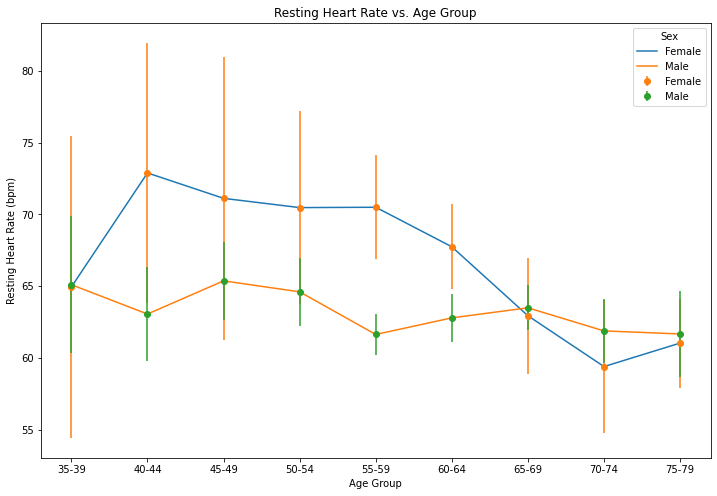

In [9]:
# Sort labels for consistent x-axis ordering
labels = sorted(df['age_group'].unique())
summary_df['xaxis'] = summary_df['age_group'].map(lambda x: labels.index(x)).astype('float')

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='mean_rhr', hue='sex', data=summary_df, ci=None)


# Plot error bars for confidence intervals
for sex in summary_df['sex'].unique():
    subset = summary_df[summary_df['sex'] == sex]
    plt.errorbar(subset['xaxis'], subset['mean_rhr'], yerr=subset['ci'], fmt='o', label=sex)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Age Group')
plt.ylabel('Resting Heart Rate (bpm)')
plt.title('Resting Heart Rate vs. Age Group')
plt.legend(title='Sex')
plt.show()

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see the resting heart rate (RHR) peaks around the age group 40-44 with a mean RHR of 72.88 bpm and then generally decreases as age increases, reaching the lowest mean RHR of 59.39 bpm in the 70-74 age group.

> 2. For men, we see the highest mean RHR for men is 65.09 bpm in the 35-39 age group, and it gradually decreases to 61.66 bpm by the 75-79 age group.

> 3 & 4. What are some possible reasons for what we see in our data? In comparison to men, Across most age groups, women have a higher mean RHR compared to men. This is consistent with existing literature which often suggests that women tend to have slightly higher resting heart rates than men, possibly due to differences in heart size, hormonal influences, and metabolic demands.

> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results? Increase Sample Size: Gathering more data, especially in underrepresented groups, would provide more reliable estimates and narrower confidence intervals. Control for Confounding Factors: Collect data on other variables such as physical activity levels, medication use, and health conditions that could influence RHR. This would help in understanding whether the observed differences are due to sex and age or other factors. Longitudinal Studies: Following individuals over time to observe changes in RHR with aging can provide more insight into the natural progression of RHR changes rather than relying on cross-sectional data. Comparative Studies: Conducting studies that compare different populations or subgroups could help determine if the trends observed are generalizable or specific to certain groups.

> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How? Did the RHR Increase Then Decrease with Age?: The data suggests that RHR does not strictly follow the hypothesized pattern of increasing until middle age and then decreasing. For both sexes, the highest mean RHR occurs around middle age (40-44 for women, 35-39 for men), but the decrease thereafter is not consistent across all age groups. The data provides partial validation for the trend with the highest mean RHR in middle age groups, but the subsequent decline is modest, especially in men.